In [32]:
import sys
import os

# Standard modules used through the notebook 
import numpy as np
import matplotlib.pyplot as plt

import utils
import ba_utils

# list the tiff images available in the remote folder
IARPAurl = 'http://menthe.ovh.hw.ipol.im:80/IARPA_data/cloud_optimized_geotif'
myimages = utils.listFD(IARPAurl, 'TIF')

# sort the images by acquisition date
myimages = sorted(myimages, key=utils.acquisition_date)
print('Found {} images'.format(len(myimages)))

os.chdir('../s2p/')
from s2plib import rpc_utils
myrpcs = [rpc_utils.rpc_from_geotiff(x) for x in myimages]
print('Finished loading RPC coefficients')
os.chdir('../IS18/')

Found 50 images
Finished loading RPC coefficients


In [33]:
# frist 10 images from IARPA challenge approximated as projective cameras

cam_model = 'Perspective'
P_crop = [np.array([[-1.03351352e-01, -7.59381208e-02, -7.83455344e-03, -8.56703538e+04],
                    [ 2.27322699e-02, -4.31209301e-02,  1.18870846e-01,  1.70900775e+05],
                    [-9.54959091e-08,  1.15402384e-07,  4.32585284e-08,  1.00000000e+00]]),
          np.array([[ 4.98547823e-01,  2.88967472e-01, -8.63624983e-03, -1.00740208e+05],
                    [-1.36008509e-01,  2.20055378e-01, -5.14469288e-01, -4.86202473e+05],
                    [-5.30702847e-08,  9.08545724e-08,  7.35698633e-08,  1.00000000e+00]]),
          np.array([[-1.53751865e-01, -1.09565497e-01, -9.12971742e-03, -1.03087318e+05],
                    [ 5.95315949e-02, -9.62004017e-02,  1.51129753e-01, -5.25765658e+04],
                    [-7.40058473e-08,  9.49438584e-08,  8.66109224e-08,  1.00000000e+00]]),
          np.array([[-3.72673270e-01, -4.65059169e-01, -1.37881428e-01, -1.56151274e+06],
                    [ 1.48788818e-01, -2.75262789e-01,  5.24003130e-01,  2.37546025e+05],
                    [-8.12728491e-08,  4.55468905e-08,  1.01458661e-07,  1.00000000e+00]]),
          np.array([[-6.00750426e-01, -8.99741685e-02,  1.59844287e-01,  1.81797594e+06],
                    [ 1.84084536e-01, -3.16412987e-01,  5.10287520e-01, -9.33470280e+04],
                    [-1.98830936e-08,  1.27660902e-07,  4.26959451e-08,  1.00000000e+00]]),
          np.array([[-1.43233241e-01, -1.32390141e-01, -2.60006845e-02, -2.95041940e+05],
                    [ 8.12410274e-02, -1.14890586e-01,  1.37472852e-01, -2.45116628e+05],
                    [-8.64891209e-08,  6.94059128e-08,  1.07614443e-07,  1.00000000e+00]])]
n_cam = len(P_crop)
 
x_lim = (2742908.8446473973, 2743517.2821114566)
y_lim = (-4491542.355014217, -4490964.3978495635)
z_lim = (-3591597.5522590503, -3591199.760935485)
print('X interval:', x_lim)
print('Y interval:', y_lim)
print('Z interval:', z_lim)

print('\nLoaded projective matrices and delimited the 3D world')


X interval: (2742908.8446473973, 2743517.2821114566)
Y interval: (-4491542.355014217, -4490964.3978495635)
Z interval: (-3591597.5522590503, -3591199.760935485)

Loaded projective matrices and delimited the 3D world


### Generate Synthetic Feature Tracks

Generate as much feature tracks as desired. Then add Gaussian noise to the 3D coordinates of the points.

In [34]:
# this code generates random synthetic feature tracks in the space defined by (x_lim, y_lim, z_lim)

n_pts = 2000  # number of desired 3D points

feature_tracks_pts = np.zeros((n_pts, 2, n_cam))
r = np.zeros((n_pts, n_cam))
pts_3d_gt = np.zeros((n_pts,3))
n_success = 0
while n_success < n_pts:
    
    successful_3d_point = False
    
    while not successful_3d_point:
        
        successful_3d_point = True
        
        # select number of cameras where the point is seen
        n_im_where_visible = np.random.randint(2, n_cam+1, 1)[0]
    
        # generate camera indices
        ind_im_where_visible = np.unique(np.random.randint(0, n_cam, n_im_where_visible))
        
        if len(ind_im_where_visible) < 2:
            successful_3d_point = False
    
        # generate random 3d point within the established limits
        a, b = x_lim[0], x_lim[1]
        x = (b - a) * np.random.random_sample() + a
        a, b = y_lim[0], y_lim[1]
        y = (b - a) * np.random.random_sample() + a
        a, b = z_lim[0], z_lim[1]
        z = (b - a) * np.random.random_sample() + a
        current_pt3d = np.vstack((x,y,z,1.))

        feature_tracks_pts[n_success,:,:] = np.zeros((1,2,n_cam))
        r[n_success,:] = np.zeros((1,n_cam))
        for im_ind in ind_im_where_visible:
            # get 2d projection in current image and check there are no negative coordinates
            current_pt2d = P_crop[im_ind] @ current_pt3d
            current_pt2d = current_pt2d[:2, :] / current_pt2d[2, :]
            feature_tracks_pts[n_success,:,im_ind] = current_pt2d.ravel()
            r[n_success,im_ind] = 1
            
            if len(current_pt2d[current_pt2d<0]) > 0:
                successful_3d_point = False
            
        if successful_3d_point:
                pts_3d_gt[n_success,:] = current_pt3d[:3, :].ravel() / current_pt3d[3, :]
                successful_3d_point = True
                n_success += 1

C = np.around(ba_utils.corresp_matrix_from_tracks(feature_tracks_pts, r), 6)

# add noise
pts_3d_noisy = np.random.normal(pts_3d_gt, 5.)

print('Real  3D location:', pts_3d_gt[0,:].ravel())
print('Noisy 3D location:', pts_3d_noisy[0,:].ravel())

print('\nSynthetic feature tracks successfully generated')

Real  3D location: [ 2742999.52160656 -4491232.35198729 -3591312.68085648]
Noisy 3D location: [ 2742990.75743605 -4491237.98488244 -3591300.71368329]

Synthetic feature tracks successfully generated


### Initialize Bundle Adjustment parameters

In [35]:
'''
INPUT PARAMETERS FOR BUNDLE ADJUSTMENT
'cam_params': (n_cam, 12), initial projection matrices. 1 row = 1 camera estimate.
              first 3 elements of each row = R vector, next 3 = T vector, then f and two dist. coef.
'pts_3d'    : (n_pts, 3) contains the initial estimates of the 3D points in the world frame.
'cam_ind'   : (n_observations,), indices of cameras (from 0 to n_cam - 1) involved in each observation.
'pts_ind'   : (n_observations,) indices of points (from 0 to n_points - 1) involved in each observation.
'pts_2d'    : (n_observations, 2) 2-D coordinates of points projected on images in each observations.
'''
pts_3d = pts_3d_noisy.copy()
pts_3d_opt = pts_3d_noisy.copy()
cam_params, cam_params_opt, properR_axis, pts_2d, cam_ind, pts_ind, ba_params \
= ba_utils.set_ba_params(P_crop, C, cam_model, R_params='Rodriguez', opt_X=True, opt_R=True, opt_T=False, opt_K=False)

print('pts_2d.shape:{}  pts_ind.shape:{}  cam_ind.shape:{}'.format(pts_2d.shape, pts_ind.shape, cam_ind.shape))
print('pts_3d.shape:{}  cam_params.shape:{}\n'.format(pts_3d.shape, cam_params.shape))
print('Bundle Adjustment parameters defined')

if ba_params['n_params'] > 0 and ba_params['opt_X']:
    print('  -> Both camera parameters and 3D points will be optimized')
elif ba_params['n_params'] > 0 and not ba_params['opt_X']:
    print('  -> Only the camera parameters will be optimized')
else:
    print('  -> Only 3D points will be optimized')

pts_2d.shape:(5711, 2)  pts_ind.shape:(5711,)  cam_ind.shape:(5711,)
pts_3d.shape:(2000, 3)  cam_params.shape:(6, 11)

Bundle Adjustment parameters defined
  -> Both camera parameters and 3D points will be optimized


### Run BA


Shape of matrix A: 11422x6018
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.1596e+06                                    1.19e+10    
       1              2         1.8218e-04      1.16e+06       3.89e+02       2.76e+05    
       2              3         9.2384e-09      1.82e-04       2.45e+00       1.84e+02    
`xtol` termination condition is satisfied.
Function evaluations 3, initial cost 1.1596e+06, final cost 9.2384e-09, first-order optimality 1.84e+02.
Optimization took 0 seconds


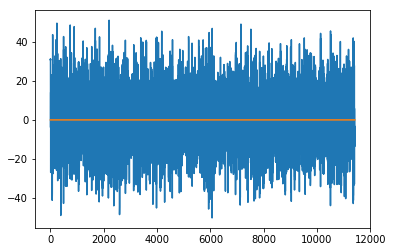

In [36]:
import time
from scipy.optimize import least_squares, minimize

# compute loss value and plot residuals at the initial parameters
x0 = np.hstack((cam_params_opt.ravel(), pts_3d_opt.ravel()))
f0 = ba_utils.fun(x0, cam_ind, pts_ind, pts_2d, properR_axis, cam_params, pts_3d, ba_params)
plt.plot(f0)

# define jacobian
A = ba_utils.bundle_adjustment_sparsity(cam_ind, pts_ind, ba_params)

# run bundle adjustment
t0 = time.time()
res = least_squares(ba_utils.fun, x0, jac_sparsity=A, verbose=2, x_scale='jac',
                    method='trf', ftol=1e-4, #loss='soft_l1', f_scale = 5.0,
                    args=(cam_ind, pts_ind, pts_2d, properR_axis, cam_params, pts_3d, ba_params))

t1 = time.time()
print("Optimization took {0:.0f} seconds".format(t1 - t0))

#plot residuals at the found solution
plt.plot(res.fun);

# recover BA output
pts_3d_ba, cam_params_ba, P_crop_ba = ba_utils.get_ba_output(res.x, ba_params, properR_axis, cam_params, pts_3d)

### Project initial and refined 3D location

Real  3D location: [ 2742999.52160656 -4491232.35198729 -3591312.68085648]
Noisy 3D location: [ 2742990.75743605 -4491237.98488244 -3591300.71368329]
3D location a. BA: [ 2742999.49821759 -4491232.38932517 -3591312.66311798] 

 ----> Real 2D loc in im 2  (sol) =  [724.96592422 381.73419926]
 ----> Proj 2D loc in im 2  b. BA =  [756.11383759 412.44058492]
 ----> Proj 2D loc in im 2  a. BA =  [724.96592378 381.73419936] 

 ----> Real 2D loc in im 3  (sol) =  [522.56358951 402.32733078]
 ----> Proj 2D loc in im 3  b. BA =  [542.90999899 433.63662522]
 ----> Proj 2D loc in im 3  a. BA =  [522.56359011 402.32733051] 

 ----> Real 2D loc in im 5  (sol) =  [632.24098439 306.53382294]
 ----> Proj 2D loc in im 5  b. BA =  [658.39774336 331.00165328]
 ----> Proj 2D loc in im 5  a. BA =  [632.24098416 306.53382307] 

Initial Reprojection Error:  36228.460392083114
Reprojection Error with BA:  9.56048523245836e-13


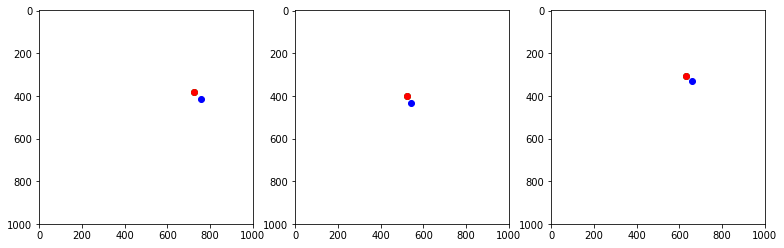

In [39]:
p_ind = 0 # feature track index
im_ind = [k for k, j in enumerate(range(n_cam)) if not np.isnan(C[j*2,p_ind])]
reprojection_error, reprojection_error_ba  = 0., 0.
cont = -1
_,f = plt.subplots(1, len(im_ind), figsize=(13,10))
for i in im_ind:   
    cont += 1
    
    p_2d_gt = feature_tracks_pts[p_ind,:,i]
    pt_3d_ba = np.expand_dims(pts_3d_ba[p_ind,:], axis=1).T
    proj = P_crop_ba[i] @ np.expand_dims(np.hstack((pts_3d_ba[p_ind,:], np.ones(1))), axis=1)
    p_2d_proj_ba = proj[0:2,:] / proj[-1,-1]
    proj = P_crop[i] @ np.expand_dims(np.hstack((pts_3d_noisy[p_ind,:], np.ones(1))), axis=1)
    p_2d_proj = proj[0:2,:] / proj[-1,-1]
    
    reprojection_error += np.sum(p_2d_proj - p_2d_gt) ** 2
    reprojection_error_ba += np.sum(p_2d_proj_ba - p_2d_gt) ** 2
    
    if cont == 0:
        print('Real  3D location:', pts_3d_gt[p_ind,:].ravel())
        print('Noisy 3D location:', pts_3d_noisy[p_ind,:].ravel())
        print('3D location a. BA:', pts_3d_ba[p_ind,:].ravel(), '\n')
    
    print(' ----> Real 2D loc in im', i, ' (sol) = ', p_2d_gt)
    print(' ----> Proj 2D loc in im', i, ' b. BA = ', p_2d_proj.ravel())
    print(' ----> Proj 2D loc in im', i, ' a. BA = ', p_2d_proj_ba.ravel(), '\n')
    
    im = 255.*np.ones((1000,1000))
    f[cont].imshow(im.squeeze(), cmap="gray", vmin=0, vmax=255)
    f[cont].plot(*p_2d_gt, "go")
    f[cont].plot(*p_2d_proj, "bo")
    f[cont].plot(*p_2d_proj_ba, "ro")
    
print('Initial Reprojection Error: ', reprojection_error)
print('Reprojection Error with BA: ', reprojection_error_ba)

In [41]:
# COMPUTE TOTAL REPROJECTION ERRORS (with all tracks)

reprojection_error = 0
reprojection_error_ba = 0

for p_ind in range(n_pts): # feature track index
    im_ind = [k for k, j in enumerate(range(n_cam)) if r[p_ind,j]!=0]
    for i in im_ind:   
        
        p_2d_gt = feature_tracks_pts[p_ind,:,i]
        pt_3d_ba = np.expand_dims(pts_3d_ba[p_ind,:], axis=1).T
        proj = P_crop_ba[i] @ np.expand_dims(np.hstack((pts_3d_ba[p_ind,:], np.ones(1))), axis=1)
        p_2d_proj_ba = proj[0:2,:] / proj[-1,-1]
        proj = P_crop[i] @ np.expand_dims(np.hstack((pts_3d_noisy[p_ind,:], np.ones(1))), axis=1)
        p_2d_proj = proj[0:2,:] / proj[-1,-1]
    
        reprojection_error += np.sum(p_2d_proj - p_2d_gt) ** 2
        reprojection_error_ba += np.sum(p_2d_proj_ba - p_2d_gt) ** 2

print('reprojection error: ', reprojection_error)
print('reprojection error after BA: ', reprojection_error_ba)


reprojection error:  9633583.314232087
reprojection error after BA:  8.392389402604873e-08
